In [1]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# model class

# Define the bottleneck block for deeper ResNet
class Bottleneck(nn.Module):
    expansion = 4  # Expansion factor for the bottleneck

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # First 1x1 convolution reduces dimensionality
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 3x3 convolution applies spatial processing
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Final 1x1 convolution expands dimensionality back
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x  # Preserve input for residual connection
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += identity  # Add residual connection
        out = self.relu(out)
        return out

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


In [30]:
def load_model(model_path, device):
    model = ResNet50()  # Initialize model architecture
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# for multi-class classification

def plot_confusion_matrix(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.magma)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(np.arange(num_classes))
    plt.yticks(np.arange(num_classes))
    plt.show()

def evaluate_resnet(model, dataloader, device):
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # Convert probabilities to class predictions
    class_preds = np.argmax(all_preds, axis=1)
    class_targets = all_targets

    # Compute metrics
    accuracy = accuracy_score(class_targets, class_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(class_targets, class_preds, average='macro')

    # Plot confusion matrix
    plot_confusion_matrix(class_targets, class_preds, num_classes=all_preds.shape[1])

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }



# for multi-label classification
# def evaluate_resnet(model, dataloader, device):
#     all_preds = []
#     all_targets = []

#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = model(inputs)
#             preds = torch.sigmoid(outputs)  # Convert logits to probabilities

#             all_preds.append(preds.cpu())
#             all_targets.append(targets.cpu())

#     all_preds = torch.cat(all_preds).numpy()
#     all_targets = torch.cat(all_targets).numpy()
#     print(all_targets)
#     # Binarize predictions (using threshold 0.5)
#     bin_preds = (all_preds > 0.5).astype(int)

#     # Compute metrics
#     accuracy = accuracy_score(all_targets, bin_preds)
#     precision, recall, f1, _ = precision_recall_fscore_support(all_targets, bin_preds, average='micro')
#     roc_auc = roc_auc_score(all_targets, all_preds, average='macro')

#     # Plot ROC curves
#     plot_roc_curves(all_targets, all_preds, all_targets.shape[1])

#     return {
#         "Accuracy": accuracy,
#         "Precision": precision,
#         "Recall": recall,
#         "F1-score": f1,
#         "AUROC": roc_auc
#     }

# def plot_roc_curves(y_true, y_scores, num_classes):
#     plt.figure(figsize=(10, 8))
#     all_fpr = []
#     all_tpr = []
#     all_roc_auc = []

#     for i in range(num_classes):
#         fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
#         roc_auc = auc(fpr, tpr)
#         all_fpr.append(fpr)
#         all_tpr.append(tpr)
#         all_roc_auc.append(roc_auc)
#         plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

#     # Plot macro-average ROC curve
#     mean_fpr = np.linspace(0, 1, 100)
#     mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
#     mean_auc = auc(mean_fpr, mean_tpr)
#     plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Macro-average (AUC = {mean_auc:.2f})')

#     plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curves')
#     plt.legend(loc='lower right')
#     plt.show()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# initializing the model and loading the weights
model_path = "/content/drive/MyDrive/sat_classifyer_pytorch/250225_ResNet/best_250225.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = load_model(model_path, device)


cpu


<ipython-input-3-ac6c69f66817>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [6]:
#loading the test data like we loaded training and validation data
test_data_dir = "/content/drive/MyDrive/sat_classifyer_pytorch/data/test"
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

#load the test data into batches
batch_size = 32
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 2, pin_memory = True)


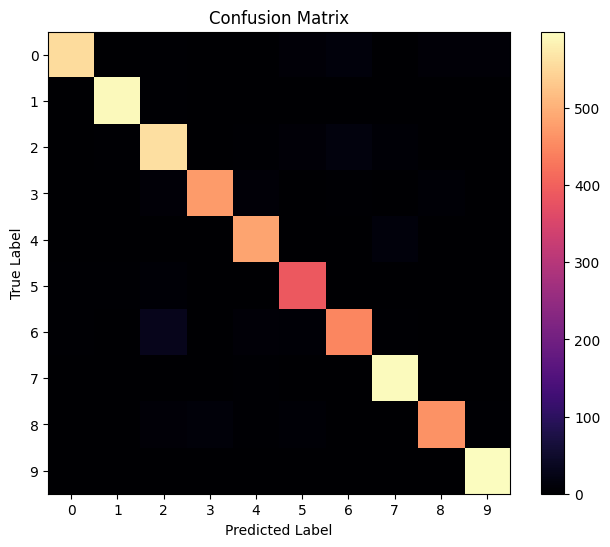

In [31]:
results = evaluate_resnet(model, test_dl, device)

In [10]:
all_preds, all_targets = results

In [11]:
class_preds = np.argmax(all_preds, axis=1)

In [17]:
np.unique(class_preds == all_targets)

array([False,  True])

In [14]:
all_targets

array([0, 0, 0, ..., 9, 9, 9])

In [18]:
accuracy = accuracy_score(all_targets, class_preds)
accuracy

0.9541165587419056

In [19]:
precision, recall, f1, _ = precision_recall_fscore_support(all_targets, class_preds, average='macro')


In [20]:
print(precision, recall, f1)

0.9534938803796059 0.9528358024691359 0.9528638652896472


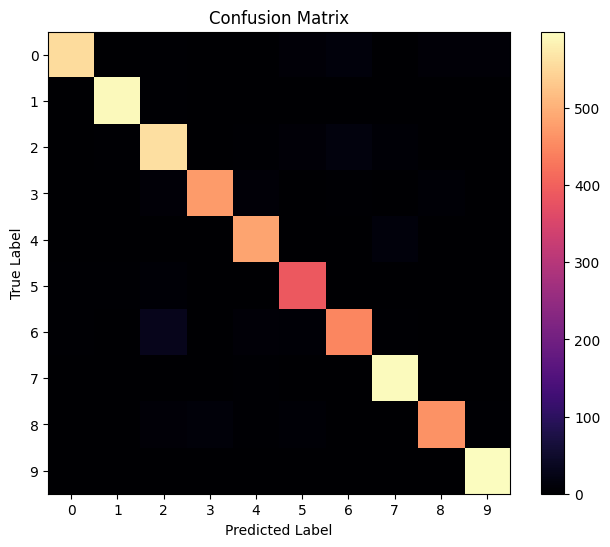

In [29]:
plot_confusion_matrix(all_targets, class_preds, num_classes=all_preds.shape[1])
